In [126]:
#!pip install tensorflow
#!pip install tensorflow pandas --quiet
#!pip install matplotlib


In [127]:

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle

In [128]:
# Step 2: Load Dataset
df = pd.read_csv("15K_Names_Dataset_MLTraining.csv")
df.head()

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M


In [129]:
# Step 3: Preprocessing - cleanup
# Drop any rows with missing values
df = df.dropna(subset=["Name", "Gender"])

# Normalize case
df['Name'] = df['Name'].str.strip().str.lower()
df['Gender'] = df['Gender'].str.strip().str.upper()

# Filter only 'male' and 'female'
df = df[df['Gender'].isin(['M', 'F'])]

print(df)
print(df.shape) #initial shape: 15000 rows, 2 columns

           Name Gender
0         james      M
1          john      M
2        robert      M
3       michael      M
4       william      M
...         ...    ...
14995  euphemia      F
14996    gordon      F
14997    kaylon      F
14998  kennadie      F
14999    lynnda      F

[15000 rows x 2 columns]
(15000, 2)


In [130]:
# Step 4: Basic Data Exploration
print(df.info())
print(df['Gender'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    15000 non-null  object
 1   Gender  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB
None
Gender
F    9006
M    5994
Name: count, dtype: int64


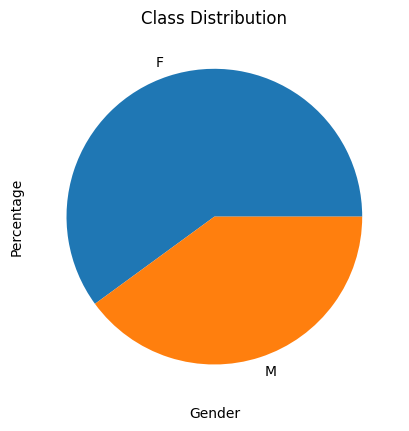

In [131]:
# display the class distribution
df['Gender'].value_counts(normalize=True) * 100

df['Gender'].value_counts(normalize=True).plot(kind='pie', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [132]:
# We need 50% distribution for both classes
#print(df)
# Split by class
df_male = df[df['Gender'] == 'M']
df_female = df[df['Gender'] == 'F']

print(df_male)
print(df_female)
print(df_male.shape)
print(df_female.shape)
# Undersample female to match male
df_female_balanced = df_female.sample(n=len(df_male), random_state=42)

print(df_female_balanced)

# Combine
df_balanced = pd.concat([df_male, df_female_balanced]).sample(frac=1, random_state=42)  # shuffle
# display the class distribution
df_balanced['Gender'].value_counts(normalize=True) * 100

           Name Gender
0         james      M
1          john      M
2        robert      M
3       michael      M
4       william      M
...         ...    ...
14977     rikki      M
14987  demetrus      M
14988    dillen      M
14989     izell      M
14990       moe      M

[5994 rows x 2 columns]
            Name Gender
5           mary      F
14     elizabeth      F
15      patricia      F
16      jennifer      F
19         linda      F
...          ...    ...
14995   euphemia      F
14996     gordon      F
14997     kaylon      F
14998   kennadie      F
14999     lynnda      F

[9006 rows x 2 columns]
(5994, 2)
(9006, 2)
           Name Gender
14504     azlyn      F
11006  christyn      F
12549   nikkole      F
5289      nilda      F
1672      abbie      F
...         ...    ...
13760  shealynn      F
1571      brynn      F
3867    tressie      F
4448     blaire      F
10161    alijah      F

[5994 rows x 2 columns]


Gender
M    50.0
F    50.0
Name: proportion, dtype: float64

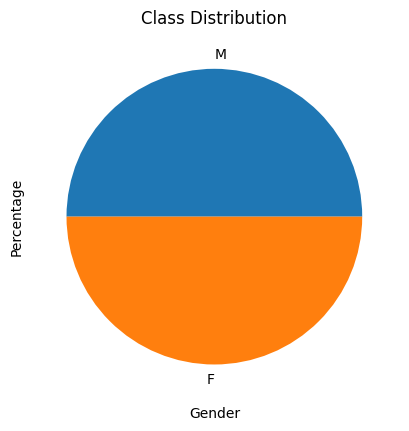

In [133]:
df_balanced['Gender'].value_counts(normalize=True).plot(kind='pie', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [134]:
#Optional: resize the dataset to 5000 rows for faster training
#df_balanced = df_balanced.sample(n=5000, random_state=42).reset_index(drop=True)

In [135]:
# Step 5: Preprocessing - encode/tokenize
names = df_balanced['Name'].astype(str).values
genders = df_balanced['Gender'].values

# Encode gender labels to 0/1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(genders)

# Tokenize names (character-level)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names)
sequences = tokenizer.texts_to_sequences(names)

# Pad sequences
maxlen = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=maxlen)
y = np.array(labels)


In [136]:
print(df_balanced)
print (df_balanced.shape)
print(labels)
print(X.shape, y.shape)
print(X)
print(y)

          Name Gender
3613    brandt      M
7924   aminata      F
3002   journee      F
10249    blima      F
1232   gustavo      M
...        ...    ...
6183   angelyn      F
12935   dupree      M
13444    navin      M
1993      aldo      M
3852   kyndall      F

[11988 rows x 2 columns]
(11988, 2)
[1 0 0 ... 1 1 0]
(11988, 14) (11988,)
[[ 0  0  0 ...  3 11  9]
 [ 0  0  0 ...  1  9  1]
 [ 0  0  0 ...  3  2  2]
 ...
 [ 0  0  0 ... 19  4  3]
 [ 0  0  0 ...  6 11  7]
 [ 0  0  0 ...  1  6  6]]
[1 0 0 ... 1 1 0]


In [137]:
# Step 6: Shuffle and split manually
dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=len(X), seed=42)

# Convert back to numpy for manual split
X_shuffled, y_shuffled = [], []
for features, label in dataset:
    X_shuffled.append(features.numpy())
    y_shuffled.append(label.numpy())

# Train/test split
# 80% for training, 20% for testing
split_index = int(0.8 * len(X))
X_train = np.array(X_shuffled[:split_index])
y_train = np.array(y_shuffled[:split_index])
X_test = np.array(X_shuffled[split_index:])
y_test = np.array(y_shuffled[split_index:])


In [138]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("Tokenized name:", X_train[0])
print("Name:", df_balanced['Name'][0])
print("Label:", y_train[0])
print("Gender:", df_balanced['Gender'][0])

(9590, 14) (9590,)
(2398, 14) (2398,)
Tokenized name: [ 0  0  0  0  0  0  0  6  1  9  4 22  1 12]
Name: james
Label: 0
Gender: M


In [139]:
# Step 7: Build Model
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size = Embedding input_dim:", vocab_size)

# Using LSTM model arhitecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

# Hyperparameters fine tuning:
#-> Embedding dimension: Size of the vector space (output_dim) — typically 16, 32, 64. Used: 32
#-> LSTM units: Number of hidden units in the LSTM — try 32, 64, 128. Used: 32
#-> Dropout rate: Prevents overfitting — try 0.3, 0.5. Used: 0.5
#-> Learning rate: Use a custom learning rate in the optimizer, default for Adam is 0.001, but you can try 0.0001 or 0.01. Used: default value = 0.001



Vocab size = Embedding input_dim: 27


In [140]:
# Step 8: Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #prevent overfitting

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

# Hyperparameters fine tuning:
# Batch size: Number of samples per gradient update — try 32, 64, 128.
# Number of epochs: More isn't always better — test 5 to 30.

#overfitting epochs: 100, no early stopping
#underfitting epochs: 5, no early stopping
#bestfit epochs: 50, batch_size: 64

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6288 - loss: 0.6525 - val_accuracy: 0.7786 - val_loss: 0.4798
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7676 - loss: 0.4956 - val_accuracy: 0.7944 - val_loss: 0.4594
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7737 - loss: 0.4879 - val_accuracy: 0.7952 - val_loss: 0.4525
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7735 - loss: 0.4881 - val_accuracy: 0.7998 - val_loss: 0.4521
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7853 - loss: 0.4685 - val_accuracy: 0.8023 - val_loss: 0.4478
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7909 - loss: 0.4659 - val_accuracy: 0.7994 - val_loss: 0.4452
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7884 - loss: 0.4661 - val_accuracy: 0.8040 - val_loss: 0.4434
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7846 - loss: 0.4681 - val_accuracy: 0.

In [141]:
# Step 9: Evaluate on Test Set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%") #best: 82.40%

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8189 - loss: 0.4107
Test Accuracy: 82.03%


In [ ]:
# View the structure of the model after training
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 14, 32)         │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,189 (254.65 KB)

 Trainable params: 21,729 (84.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 43,460 (169.77 KB)

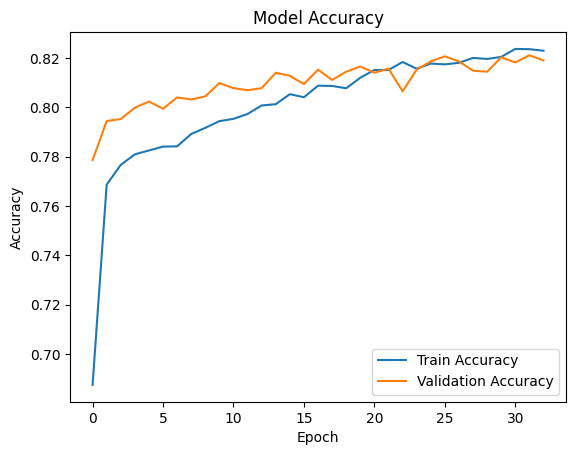

In [142]:
# Step 10: Visualize Training History

# Model's Accuracy evolution during training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


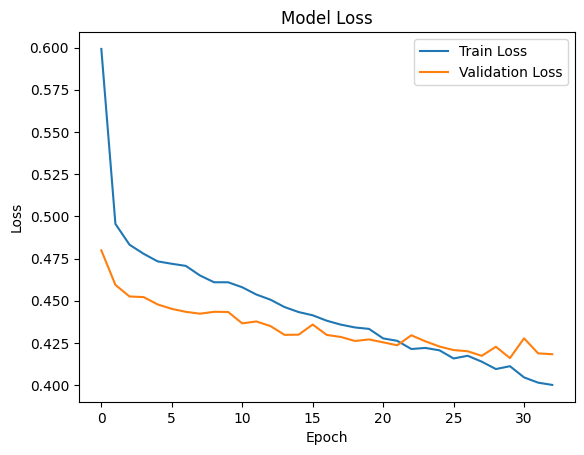

In [143]:
# Model's Loss evolution durring training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [144]:
# Step 11: Predict Gender for New Names

# Predicted valuea are between 0 and 1
# A predicted value from 0 to 0.5 represents Female(F) 
# A predicted value from 0.5 to 1 represents Male(M)
 
names_train = np.array(names[:split_index])
def predict_gender(model, names, name, expected_gender=None):
    name = name.lower()  # normalize
    sequence = tokenizer.texts_to_sequences([name])
    padded = pad_sequences(sequence, maxlen=maxlen)
    pred_prob = model.predict(padded)[0][0] # the actual prediction is done here, it's also called inference
    
    predicted_label = label_encoder.inverse_transform([int(round(pred_prob))])[0]
    print(f"Name: {name.capitalize()} → Predicted Gender: {predicted_label} (Confidence: {pred_prob:.2f}) Expected: {expected_gender} {'' if predicted_label == expected_gender else '!!!'} Seen: {'Yes' if name.lower() in names else 'No'}")

# Examples international names
print(predict_gender(model, names_train, "Liam", "M"))
print(predict_gender(model, names_train, "Isabella", "F"))
print(predict_gender(model, names_train, "Zoe", "F"))
print(predict_gender(model, names_train, "Autumn", "F"))
print(predict_gender(model, names_train, "Gene", "M"))
print(predict_gender(model, names_train, "Ana", "F"))
print(predict_gender(model, names_train, "Ana Maria", "F"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Name: Liam → Predicted Gender: M (Confidence: 0.68) Expected: M  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Isabella → Predicted Gender: F (Confidence: 0.00) Expected: F  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Name: Zoe → Predicted Gender: M (Confidence: 0.71) Expected: F !!! Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Autumn → Predicted Gender: M (Confidence: 0.93) Expected: F !!! Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Gene → Predicted Gender: F (Confidence: 0.39) Expected: M !!! Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Ana → Predicted Gender: F (Confidence: 0.07) Expected: F  Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Ana maria → Predicted Gender: F (Confidence: 0.01) Expected: F  Seen: No
None


In [145]:
# Trying out some italian names
print(predict_gender(model, names_train, "Marco", "M"))
print(predict_gender(model, names_train, "Romeo", "M"))
print(predict_gender(model, names_train, "Chiara", "F"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Marco → Predicted Gender: M (Confidence: 0.85) Expected: M  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Romeo → Predicted Gender: M (Confidence: 0.83) Expected: M  Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Name: Chiara → Predicted Gender: F (Confidence: 0.12) Expected: F  Seen: No
None


In [146]:
# Examples romanian names in pairs
print(predict_gender(model, names_train, "Florin", "M"))
print(predict_gender(model, names_train, "Florina", "F"))
print(predict_gender(model, names_train,"Marian", "M"))
print(predict_gender(model, names_train,"Maria", "F"))
print(predict_gender(model, names_train,"Marcel", "M"))
print(predict_gender(model, names_train,"Marcela", "F"))
print(predict_gender(model, names_train,"Mihai", "M"))
print(predict_gender(model, names_train,"Mihaela", "F"))


print(predict_gender(model, names_train, "Doina", "F"))
print(predict_gender(model, names_train, "Ilinca", "F"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Name: Florin → Predicted Gender: M (Confidence: 0.73) Expected: M  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Florina → Predicted Gender: F (Confidence: 0.02) Expected: F  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Name: Marian → Predicted Gender: M (Confidence: 0.69) Expected: M  Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Name: Maria → Predicted Gender: F (Confidence: 0.03) Expected: F  Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Name: Marcel → Predicted Gender: M (Confidence: 0.68) Expected: M  Seen: Yes
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Name: Marcela → Predicted Gender: F (Confidence: 0.02) Expected: F  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Mihai → Predicted Gender: M (Confidence: 0.74) Expected: M  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Name: Mihaela → Predicted Gender: F (Confidence: 0.02) Expected: F  Seen: No
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: 

In [147]:
# observations 
# => short names might not perform well, longer names are better
# => ambigous names can become both male and female names, this is not a case that we handle in this model
# => "Mihai/Mihaela" or "Michael/Michaela" are good examples, they are 90% similar, it's detecting the diffrence in the last character that indicates the gender
# => Suggestions: run training on a dataset with just these short/ambigous names, try it out (excercise)

In [148]:
# Step 11: Save the model in Keras format
save_filename = "name_gender_model_82_trained_9590_rows.keras"
model.save(save_filename)

# Save the tokenizer and label encoder as well
# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [149]:
print(tf.__version__)

2.19.0-dev20241007
